# Dimensionalty Reduced Disease Type Classifier

- BME 230A class project winter 2019
- Andrew E. Davidson
- [aedavids@ucsc.edu](mailto:aedavids@edu?subject=SimpleModel.ipynb)

ref:
- [https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
- Chapter 8 "Dimensionality Reduction in "Hands-On Machine Learning with Scikit-learn & TensorFlow" by Aurelien Geron
- [https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60](https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60)
- [https://scikit-learn.org/stable/modules/decomposition.html#pca](https://scikit-learn.org/stable/modules/decomposition.html#pca)
- [https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_fa_model_selection.html#sphx-glr-auto-examples-decomposition-plot-pca-vs-fa-model-selection-py](https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_fa_model_selection.html#sphx-glr-auto-examples-decomposition-plot-pca-vs-fa-model-selection-py)

TODO:
- save pca to disk [https://stackoverflow.com/a/42503036/4586180](https://stackoverflow.com/a/42503036/4586180)

In [1]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ProgbarLogger
from keras.layers import Dense
from keras.layers import Dense, Input, BatchNormalization, InputLayer, Activation
from keras.models import Sequential
from keras.optimizers import Adam, SGD, Adadelta, Adagrad
from keras.regularizers import L1L2
from keras.utils import np_utils
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from sklearn.preprocessing import LabelEncoder
import sys

import tensorflow as tf

# fix random seed for reproducibility
theMeaningOfLife = 42

import keras
if "2.1.6" != keras.__version__:
    emsg = "ERROR keras version {} != 2.1.6, new version can not save and restore models".format(
        keras.__version__)
    raise ValueError(emsg)

# add path to our local modules
# assume they are in the same directory we launched the juypter server in
# /home/ubuntu/BME-230a
!pwd
localModuleDir = "."
sys.path.append(localModuleDir)

Using TensorFlow backend.


/home/ubuntu/BME-230a


## load data

In [2]:
%%time
rootDir = "/bme-230a-ebs"
sourceDataFilePath = "{}/data/tcga_target_gtex.h5".format(rootDir)
print(sourceDataFilePath)
if not os.path.isfile(sourceDataFilePath):
    emsg = "ERROR: {} not found".format(sourceDataFilePath)
    print(emsg)
    print("change rootDir")
    sys.stdout.flush()  # force error message to print
    raise ValueError(emsg)

from loadData import loadCancerDiseaseTypeTidyDataSet

ret = loadCancerDiseaseTypeTidyDataSet(rootDir)
hugoIds, diseaseLabelEncoder, XTrainNumpy, yTrainNumpy, XTestNumpy, yTestNumpy = ret
#XTestNumpy = yTestNumpy = None # clean up memory
ret = None  # clean up memory

/bme-230a-ebs/data/tcga_target_gtex.h5
sourceDataFilePath:/bme-230a-ebs/data/tcga_target_gtex.h5
CPU times: user 1.34 s, sys: 4.84 s, total: 6.18 s
Wall time: 6.18 s


In [3]:
print("XTrainNumpy.shape: {}".format(XTrainNumpy.shape))
print("yTrainNumpy.shape: {}".format(yTrainNumpy.shape))
print("XTestNumpy.shape: {}".format(XTestNumpy.shape))
XTrainNumpyShape = XTrainNumpy.shape

XTrainNumpy.shape: (8424, 58581)
yTrainNumpy.shape: (8424, 39)
XTestNumpy.shape: (2106, 58581)


In [4]:
%%time
from sklearn.decomposition import PCA
from sklearn.externals import joblib

XTrainReducedPCAFilePath = "{}/data/reducedXDiseaseTypePCA.pkl".format(rootDir)
XTrainReducedNumpyDataFilePath = "{}/data/reducedXDiseaseTypeDataSet.npz".format(
    rootDir)

if os.path.isfile(XTrainReducedNumpyDataFilePath):
    print("loading XTrainReducedNumpy and XTestReducedNumpy from {}".format(
        XTrainReducedNumpyDataFilePath))
    reducedFiles = np.load(XTrainReducedNumpyDataFilePath)
    #print(reducedFiles.files)
    XTrainReducedNumpy = reducedFiles['arr_0']
    XTestReducedNumpy = reducedFiles['arr_1']

    if os.path.isfile(XTrainReducedPCAFilePath):
        print("loading pca from {}".format(XTrainReducedPCAFilePath))
        pca = joblib.load(XTrainReducedPCAFilePath)
    else:
        raise ValueError(
            "pca is missing path:{}".format(XTrainReducedPCAFilePath))

else:
    print("running PCA")
    pca = PCA(n_components=0.95)  # account for 95% of the variance
    XTrainReducedNumpy = pca.fit_transform(XTrainNumpy)
    XTestReducedNumpy = pca.transform(XTestNumpy)
    np.savez(XTrainReducedNumpyDataFilePath, XTrainReducedNumpy,
             XTestReducedNumpy)
    print("saved numpy arrays to :{}".format(XTrainReducedNumpyDataFilePath))

    joblib.dump(pca, XTrainReducedPCAFilePath)
    print("saved pca to :{}".format(XTrainReducedPCAFilePath))

loading XTrainReducedNumpy and XTestReducedNumpy from /bme-230a-ebs/data/reducedXDiseaseTypeDataSet.npz
loading pca from /bme-230a-ebs/data/reducedXDiseaseTypePCA.pkl
CPU times: user 628 ms, sys: 1.12 s, total: 1.75 s
Wall time: 1.74 s


In [5]:
# is the juypter kernal restart durring training a memory issue?
XTrainNumpy = None  # clean up memory
XTestNumpy = None  # clean up memory

In [6]:
#print("      type(XTrainReducedNumpy:{}".format(type(XTrainReducedNumpy)))
print("     XTrainReducedNumpy.shape: {}".format(XTrainReducedNumpy.shape))
print("      XTestReducedNumpy.shape: {}".format(XTestReducedNumpy.shape))
print("            pca.n_components_: {}".format(pca.n_components_))
print("      pca.explained_variance_: {}".format(pca.explained_variance_))
print("pca.explained_variance_ratio_: {}".format(
    pca.explained_variance_ratio_))

     XTrainReducedNumpy.shape: (8424, 5895)
      XTestReducedNumpy.shape: (2106, 5895)
            pca.n_components_: 5895
      pca.explained_variance_: [2.15254990e+04 1.86303089e+04 1.64745828e+04 ... 8.72403837e+00
 8.72019841e+00 8.71888428e+00]
pca.explained_variance_ratio_: [7.24130749e-02 6.26734811e-02 5.54214888e-02 ... 2.93481904e-05
 2.93352726e-05 2.93308518e-05]


In [7]:
XTrainReducedNumpy.shape[1]

5895

## Create Model
This should be the same as the model in [disaseTypeClassifier.ipynb](disaseTypeClassifier.ipynb)

In [8]:
def multiClassClassifier(inputDim=None, outputDim=None, learningRate=0.001):
    '''
    aedwip
    '''
    classify = [
        InputLayer(input_shape=(inputDim, )),
        BatchNormalization(),
        Dense(outputDim),  # dot(input, kernel) + bias
        Activation('softmax')
    ]

    model = Sequential(classify)
    # https://keras.io/backend/#categorical_crossentropy
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(lr=learningRate),
        metrics=['accuracy'])

    return model

In [9]:
%%time
modelName = "reducedDiseaseClassifier"
# the first col of yTrainNumpy is the disease value.
# numCases is size of the prediction output
numCases = yTrainNumpy.shape[1] - 1

reducedDiseaseClassifierModel = multiClassClassifier(
    inputDim=XTrainReducedNumpy.shape[1], outputDim=numCases)

reducedDiseaseClassifierModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5895)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 5895)              23580     
_________________________________________________________________
dense_1 (Dense)              (None, 38)                224048    
_________________________________________________________________
activation_1 (Activation)    (None, 38)                0         
Total params: 247,628
Trainable params: 235,838
Non-trainable params: 11,790
_________________________________________________________________
CPU times: user 116 ms, sys: 4 ms, total: 120 ms
Wall time: 120 ms


In [10]:
%%time
# https://keras.io/callbacks/
checkPointPath = "./models/{}.chkPt".format(modelName)
callbacks = [
    # monitor valuse either 'acc' for accuracy or 'loss'
    # 'val_loss' is loss on hold if valaidation_split is set
    # 'loss' is loss on training
    # same for 'acc' and 'val_acc'
    #EarlyStopping(monitor='loss', patience=2, verbose=0),
    ModelCheckpoint(
        checkPointPath, monitor='loss', save_best_only=False, verbose=0)
    # FIXME: progbar generates run time error
    #,ProgbarLogger(count_mode='samples', stateful_metrics=None)
]

trainOneHots = yTrainNumpy[:, 1:]
history = reducedDiseaseClassifierModel.fit(
    XTrainReducedNumpy,
    trainOneHots,
    shuffle=None,  # we already shuffled
    epochs=8,  #20, #100
    batch_size=1024,
    # we already split the data
    validation_split=0.0,
    verbose=0,
    callbacks=callbacks)

CPU times: user 13.2 s, sys: 2.07 s, total: 15.3 s
Wall time: 5.3 s


In [11]:
def calculateAccuracy(model, X, y):
    '''
    AEDWIP: move this function to a util module see diseaseTypeClassifier.ipynb
    calculates accuracy

    arguments
        model: 
            a keras model that returns the output of softmax
        
        X:
            the set of data to make prediction on. Types must be numpy array
        y:
            the expected values, a numpy array with shape (n, 1) of values. Do not pass one hots
    
    returns float
    '''
    # predictions is output of softmax layer
    predictions = model.predict(X)
    predictedValuesTensor = keras.backend.argmax(predictions)

    # use keras escape hatch to tensor flow
    sess = tf.Session()
    with sess.as_default():
        predictedValuesNumpy = predictedValuesTensor.eval()

    indicators = np.equal(predictedValuesNumpy, y)
    accuracy = np.sum(indicators) / len(indicators)

    return accuracy

In [12]:
%%time
model = reducedDiseaseClassifierModel
trainAcc = calculateAccuracy(model, XTrainReducedNumpy, yTrainNumpy[:, 0])
testAcc = calculateAccuracy(model, XTestReducedNumpy, yTestNumpy[:, 0])
print("training accuracy:{}".format(trainAcc))
print("    test accuracy:{}".format(testAcc))

training accuracy:0.8066239316239316
    test accuracy:0.7288698955365622
CPU times: user 3.08 s, sys: 1.39 s, total: 4.46 s
Wall time: 986 ms


## AEDWIP refactor
a lot of the code was cut -n- pasted from diseaseTypeClassifierEval.ipynb, re-factor into util.py module

In [13]:
lastLayer = reducedDiseaseClassifierModel.layers[-1]
print(lastLayer.output.shape)

(?, 38)


In [14]:
# find which class a gene maximal activates
def largestActivation(model, m, batchSize, pca=None):
    '''
    for each featue calculates the disease type the feature makes the largest contribution to
    
    input:
        model:
        m: the number of features
        batchSize
        pca:
            if not null generates one hots of size m, then uses pca to reduce to the model
            output size
        
    returns:
        numpy array of size (m,1).
        array[i] is the disease value of the gene at position i in the feature set
    '''
    if pca:
        print("the shape of the one hots will be (1,{})".format(m))
        print("pca will reduce them to the shape to (1, {})".format(
            pca.n_components_))

    ret = np.zeros((m, 1))
    numBatches, r = divmod(m, batchSize)
    print("m:{} batchSize:{} numBatches:{} r:{}".format(
        m, batchSize, numBatches, r))
    startRowIdx = 0
    batchCount = 0
    while (batchCount < numBatches):
        if batchCount < numBatches:
            bs = batchSize
        else:
            bs = r  # short batch

        # create a feature vector one hot. We only want the activation f
        # value for a single gene
        batch = np.zeros((bs, m))
        for j in range(bs):
            # use a high value
            # when value was 1 all predictions where class 27
            batch[j, startRowIdx + j] = 1000000

        if pca:
            batch = pca.transform(batch)

        predictions = model.predict(batch)
        predictedValuesTensor = keras.backend.argmax(predictions)

        # use keras escape hatch to tensor flow
        # there is probably a better way to do this
        sess = tf.Session()
        with sess.as_default():
            predictedValuesNumpy = predictedValuesTensor.eval()

        shape = predictedValuesNumpy.shape
        ret[startRowIdx:startRowIdx + bs] = np.reshape(predictedValuesNumpy,
                                                       (shape[0], -1))

        # increment loop counts
        batchCount += 1
        startRowIdx += bs

    return ret

### High to low

In [15]:
# XTrainNumpyShape[1]
# build up one-hots for the 44 pacractic cancer genes
# to much to anlayslis. get a reought feel

# would be interesting to ry and go in reverse, one hot all hte low sort by cancer tpe

In [43]:
%%time
maxActivationsPCAFilePath = "{}/data/maxActivationsPCA.npz".format(rootDir)
if os.path.isfile(maxActivationsPCAFilePath):
    print("loading maxActivations from {}".format(maxActivationsPCAFilePath))
    maxActivationNumpyFiles = np.load(maxActivationsPCAFilePath)
    print(list(maxActivationNumpyFiles.keys()))
    maxActivations = maxActivationNumpyFiles['arr_0']
    print("maxActivations.shape:{}".format(maxActivations.shape))

else:
    print("run largestActivation() and save expected run time 18 min ")
    maxActivations = largestActivation(
        reducedDiseaseClassifierModel,
        m=XTrainNumpyShape[1],
        batchSize=6000,
        pca=pca)
    print("maxActivations.shape:{}".format(maxActivations.shape))
    np.savez(maxActivationsPCAFilePath, maxActivations)
    print("saved numpy array to :{}".format(maxActivationsPCAFilePath))

loading maxActivations from /bme-230a-ebs/data/maxActivationsPCA.npz
['arr_0']
maxActivations.shape:(58581, 1)
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 2.27 ms


In [44]:
%%capture --no-display
# turn off deprecation warnings
# https://ipython.readthedocs.io/en/stable/interactive/magics.html?highlight=capture#cellmagic-capture
disease = diseaseLabelEncoder.inverse_transform(maxActivations.astype(int))

In [46]:
dataDict = {
    "HugoId": hugoIds,
    "disease": disease.flatten(),
    "maxActDisease": maxActivations.astype(int).flatten()
}

activationDF = pd.DataFrame(data=dataDict)
activationDF.head()

,HugoId,disease,maxActDisease
0,5S_rRNA,Colon Adenocarcinoma,10
1,5_8S_rRNA,Stomach Adenocarcinoma,30
2,7SK,Acute Lymphoblastic Leukemia,0
3,A1BG,Esophageal Carcinoma,12
4,A1BG-AS1,Esophageal Carcinoma,12


In [47]:
%%capture --no-display
# turn off deprecation warnings
# https://ipython.readthedocs.io/en/stable/interactive/magics.html?highlight=capture#cellmagic-capture
countsDict = dict()
grouped = activationDF.groupby("maxActDisease")
for diseaseValue, group in grouped:
    stats = group.agg(['count'])
    dv = int(diseaseValue)
    key = "{}_{}".format(dv, diseaseLabelEncoder.inverse_transform([dv]))
    countsDict[key] = stats.values

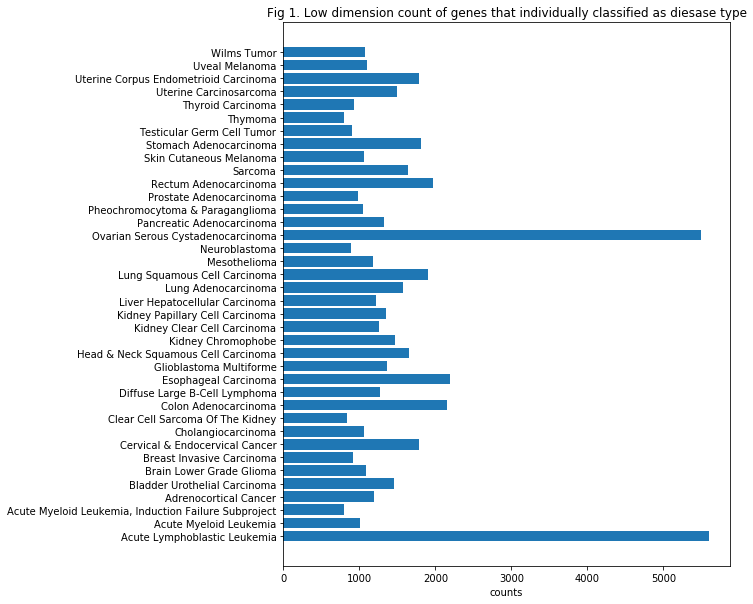

In [53]:
%%capture --no-display
# turn off deprecation warnings
# https://ipython.readthedocs.io/en/stable/interactive/magics.html?highlight=capture#cellmagic-capture

fig, ax = plt.subplots()
fig.set_size_inches(8, 10)
countsList = [v[0][0] for v in countsDict.values()]
# AEDWIP no magic number 38 = number of classes
dt = diseaseLabelEncoder.inverse_transform(range(38))
plt.barh(dt, countsList)
plt.title("Fig 1. Low dimension count of genes that individually classified as diesase type")
plt.xlabel("counts")
plt.savefig('images/dimensionaltyReducedDiseaseTypeClassifierFig1.png')

plt.show()

In [50]:
# find disease with fewest genes that individually classified as diesase type
# this is ugly. could not figure out how to do this using pandas
from math import inf
smallest = (inf, "AEDWIP")
for k, vv in countsDict.items():
    v = vv[0][0]
    if smallest[0] > v:
        smallest = (v, k)

print(smallest)

(800, "32_['Thymoma']")


In [51]:
#https://www.tutorialspoint.com/python_pandas/python_pandas_groupby.htm
groupedDF = activationDF.groupby('disease')
#groupedDF.get_group('Pancreatic Adenocarcinoma')

In [52]:
setCount = smallest[0]
smallestDiseaseValue, smallestDisease = smallest[1].split("_")
print("disease type with smallest identified gene set:{}".format(smallestDisease))
print("number of genes in set:{}".format(setCount))
groupedDF.get_group('Pancreatic Adenocarcinoma')['HugoId'].values

disease type with smallest identified gene set:['Thymoma']
number of genes in set:800


array(['AADACL2', 'AASDHPPT', 'ABCA10', ..., 'SVIL', 'SYF2P2', 'SYNGR4'],
      dtype=object)